## Load data

In [1]:
# import packages
import pandas as pd
import numpy as np

# set working directory
import os
os.chdir('/home/jovyan/work/')

In [60]:
from src.data.load_dataset import load_split_store
from sklearn.preprocessing import StandardScaler

# setup scaler
scaler = StandardScaler()

# load_split_store
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    # scaler=scaler,   # not scaling for this experiment 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.2, 
                                                                    replace_negatives=False)

## Fit XGBoost Model

#### Fit base model

In [33]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', objective='binary:logistic',
              learning_rate=0.1, max_delta_step=0, max_depth=3, eval_metric='logloss',
              min_child_weight=5, monotone_constraints='()', use_label_encoder=False,
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

#### Evaluate Model

-----------
Confusion Matrix with thresthold of 0.5:


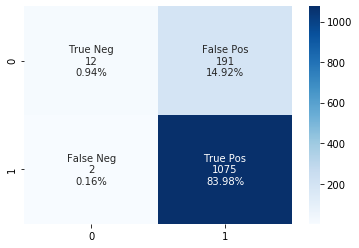

1266 out of 1280 or 99% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9981
Accuracy: 0.8492
F1: 0.9176
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.787


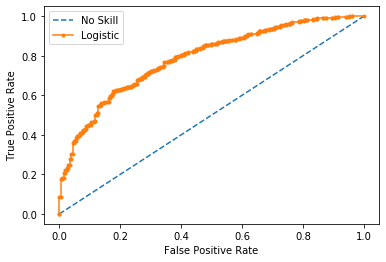

In [77]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = xgb.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

### Interpret model (Feature Entropy Importance)

In [34]:
# get feature importance from xgb model
importance_vals = xgb.feature_importances_

# calculate standard deviations
std = np.std([xgb.feature_importances_], axis=0)

indices = np.argsort(importance_vals)[::-1]

ind = [X_train.columns[x] for x in indices]

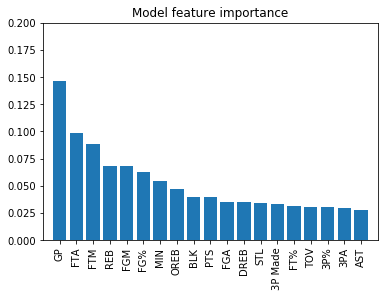

In [35]:
from matplotlib import pyplot as plt

# Plot the feature importances of the model
plt.figure()
plt.title("Model feature importance")
plt.bar(range(X_train.shape[1]), importance_vals[indices],
        yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), ind, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 0.2])
plt.show()

### Interpret model (Feature Permutation Importance)

In [61]:
xgb2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', objective='binary:logistic',
              learning_rate=0.1, max_delta_step=0, max_depth=3, eval_metric='logloss',
              min_child_weight=5, monotone_constraints='()', use_label_encoder=False,
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb2.fit(X_train.to_numpy(), y_train.to_numpy())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [62]:
from mlxtend.evaluate import feature_importance_permutation

imp_vals, _ = feature_importance_permutation(
    predict_method=xgb2.predict, 
    X=X_val.to_numpy(), #np array
    y=y_val.to_numpy(), #np array
    metric='accuracy',
    num_rounds=1,
    seed=1)

In [63]:
imp_vals

array([-0.0015625 , -0.00078125,  0.00078125, -0.0015625 ,  0.        ,
       -0.00078125,  0.00078125,  0.0015625 ,  0.        ,  0.00078125,
       -0.00078125,  0.0015625 , -0.00078125,  0.        ,  0.00234375,
        0.003125  ,  0.0015625 ,  0.        , -0.00078125])

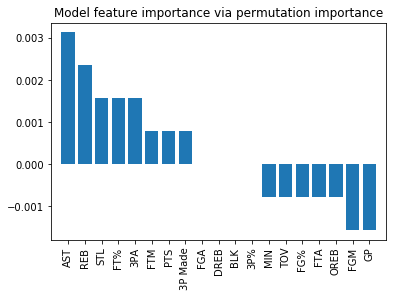

In [65]:
indices = np.argsort(imp_vals)[::-1]

ind = [X_train.columns[x] for x in indices]

plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar(range(X_train.shape[1]), imp_vals[indices])
plt.xticks(range(X_train.shape[1]), ind, rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.ylim([0, 0.01])
plt.show()

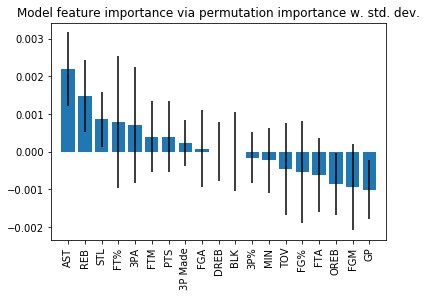

In [68]:
# Chart feature importance via permutation importance w. std. dev

imp_vals, imp_all = feature_importance_permutation(
    predict_method=xgb2.predict, 
    X=X_val.to_numpy(), #np array
    y=y_val.to_numpy(), #np array
    metric='accuracy',
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Model feature importance via permutation importance w. std. dev.")
plt.bar(range(X_train.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X_train.shape[1]), ind, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Interpratation with LIME

In [73]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    np.array(X_train),
    feature_names=X_train.columns,
    class_names=["<5y", ">5y"],
    mode='classification')

exp = explainer.explain_instance(
   np.array(X_val)[0],
   xgb2.predict_proba,
   top_labels=1,
   num_features=19)

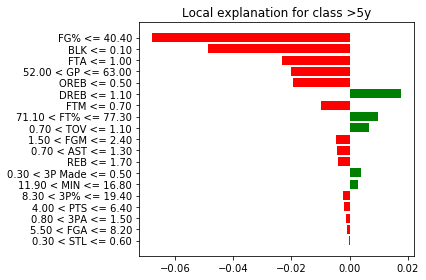

In [74]:
exp.as_pyplot_figure()

plt.tight_layout()

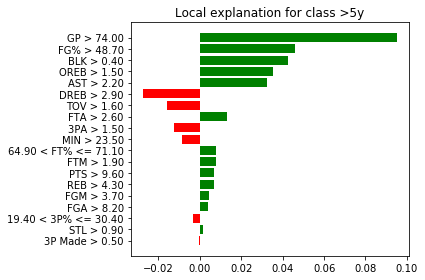

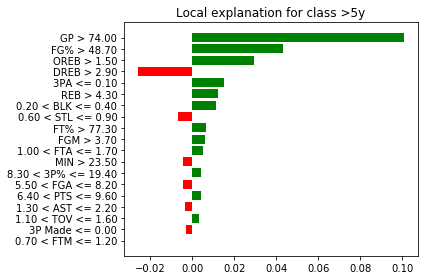

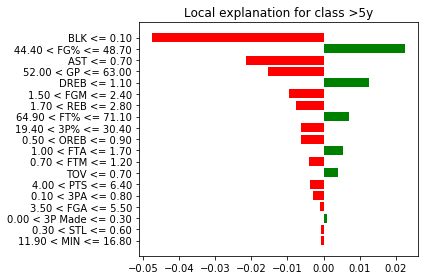

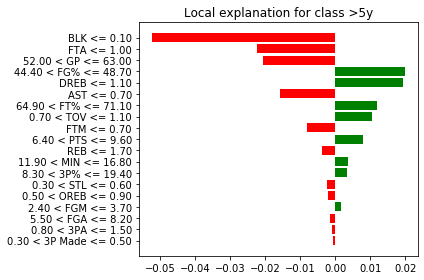

In [76]:
for i in [11, 14, 3, 6]:
    exp = explainer.explain_instance(np.array(X_val)[i], xgb2.predict_proba,
            num_features=19)
    exp.as_pyplot_figure()
    plt.tight_layout()